如果需要训练的数据大小不大，例如不到1G，那么可以直接全部读入内存中进行训练，这样一般效率最高。

但如果需要训练的数据很大，例如超过10G，无法一次载入内存，那么通常需要在训练的过程中分批逐渐读入。

使用 tf.data API 可以构建数据输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换。

### 一、构建数据管道

可以从 Numpy array, Pandas DataFrame, Python generator, csv文件, 文本文件, 文件路径, tfrecords文件等方式构建数据管道。

其中通过Numpy array, Pandas DataFrame, 文件路径构建数据管道是最常用的方法。

通过tfrecords文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecords文件，读取后再解析成tf.Example。

但tfrecords文件的优点是压缩后文件较小，便于网络传播，加载速度较快。

#### 1.1 从Numpy array构建数据管道

In [3]:
# 从Numpy array构建数据管道

import tensorflow as tf
import numpy as np 
from sklearn import datasets 
iris = datasets.load_iris()


ds1 = tf.data.Dataset.from_tensor_slices((iris["data"], iris["target"]))
for features,label in ds1.take(5):
    print(features,label)

tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


#### 1.2 从 Pandas DataFrame构建数据管道

In [4]:
# 从 Pandas DataFrame构建数据管道
import tensorflow as tf
from sklearn import datasets 
import pandas as pd
iris = datasets.load_iris()
dfiris = pd.DataFrame(iris["data"],columns = iris.feature_names)
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict("list"),iris["target"]))

for features,label in ds2.take(3):
    print(features,label)

{'sepal length (cm)': <tf.Tensor: id=76, shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: id=77, shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: id=74, shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: id=75, shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: id=81, shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: id=82, shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: id=79, shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: id=80, shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: id=86, shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: id=87, shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: id=84, shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: id=85, shape=(), dtype=float32, numpy=0.2>} tf.Tens

#### 1.3 从Python generator构建数据管道

In [5]:
# 从Python generator构建数据管道
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义一个从文件中读取图片的generator
image_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
                    "../data/cifar2/test/",
                    target_size=(32, 32),
                    batch_size=20,
                    class_mode='binary')

classdict = image_generator.class_indices
print(classdict)

def generator():
    for features,label in image_generator:
        yield (features,label)

ds3 = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))

Found 2000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


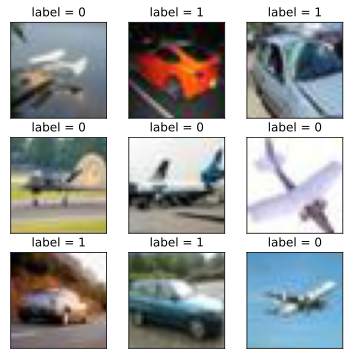

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

#### 1.4 从csv文件构建数据管道

In [7]:
# 从csv文件构建数据管道
ds4 = tf.data.experimental.make_csv_dataset(
      file_pattern = ["../data/titanic/train.csv","../data/titanic/test.csv"],
      batch_size=3, 
      label_name="Survived",
      na_value="",
      num_epochs=1,
      ignore_errors=True)

for data,label in ds4.take(2):
    print(data,label)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
OrderedDict([('PassengerId', <tf.Tensor: id=249, shape=(3,), dtype=int32, numpy=array([715, 802, 245], dtype=int32)>), ('Pclass', <tf.Tensor: id=250, shape=(3,), dtype=int32, numpy=array([2, 2, 3], dtype=int32)>), ('Name', <tf.Tensor: id=247, shape=(3,), dtype=string, numpy=
array([b'Greenberg, Mr. Samuel',
       b'Collyer, Mrs. Harvey (Charlotte Annie Tate)',
       b'Attalah, Mr. Sleiman'], dtype=object)>), ('Sex', <tf.Tensor: id=251, shape=(3,), dtype=string, numpy=array([b'male', b'female', b'male'], dtype=object)>), ('Age', <tf.Tensor: id=243, shape=(3,), dtype=float32, numpy=array([52., 31., 30.], dtype=float32)>), ('SibSp', <tf.Tensor: id=252, shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>), ('Parch', <tf.Tensor: id=248, shape=(3

#### 1.5 从文本文件构建数据管道

In [8]:
# 从文本文件构建数据管道

ds5 = tf.data.TextLineDataset(
    filenames = ["../data/titanic/train.csv","../data/titanic/test.csv"]
    ).skip(1) #略去第一行header

for line in ds5.take(5):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,,S', shape=(), dtype=string)


#### 1.6 从文件路径构建数据管道

In [9]:
ds6 = tf.data.Dataset.list_files("../data/cifar2/train/*/*.jpg")
for file in ds6.take(5):
    print(file)

tf.Tensor(b'../data/cifar2/train/automobile/4534.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/cifar2/train/automobile/3044.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/cifar2/train/airplane/1312.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/cifar2/train/automobile/3048.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/cifar2/train/automobile/2279.jpg', shape=(), dtype=string)


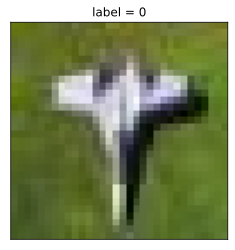

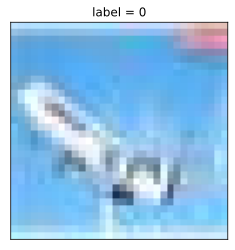

In [10]:
from matplotlib import pyplot as plt 
def load_image(img_path,size = (32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)
    return(img,label)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
for i,(img,label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img/255.0).numpy())
    plt.title("label = %d"%label)
    plt.xticks([])
    plt.yticks([])

#### 1.7 从tfrecords文件构建数据管道

In [11]:
import os
import numpy as np

# inpath：原始数据路径 outpath:TFRecord 文件输出路径
def create_tfrecords(inpath,outpath): 
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index, name in enumerate(dirs):
        class_path = inpath +"/"+ name+"/"
        for img_name in os.listdir(class_path):
            img_path = class_path + img_name
            img = tf.io.read_file(img_path)
            #img = tf.image.decode_image(img)
            #img = tf.image.encode_jpeg(img) #统一成jpeg格式压缩
            example = tf.train.Example(
               features=tf.train.Features(feature={
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                    'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.numpy()]))
               }))
            writer.write(example.SerializeToString())
    writer.close()
    
create_tfrecords("../data/cifar2/test/","../data/cifar2_test.tfrecords/")

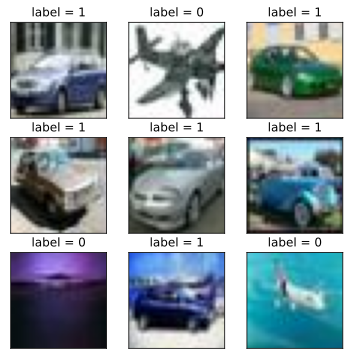

In [13]:
from matplotlib import pyplot as plt 

def parse_example(proto):
    description ={ 'img_raw' : tf.io.FixedLenFeature([], tf.string),
                   'label': tf.io.FixedLenFeature([], tf.int64)} 
    example = tf.io.parse_single_example(proto, description)
    img = tf.image.decode_jpeg(example["img_raw"])   #注意此处为jpeg格式
    img = tf.image.resize(img, (32,32))
    label = example["label"]
    return(img,label)

ds7 = tf.data.TFRecordDataset("../data/cifar2_test.tfrecords").map(parse_example).shuffle(3000)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds7.take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow((img/255.0).numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

### 二、应用数据转换

Dataset数据结构应用非常灵活，因为它本质上是一个Sequece序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。

- map: 将转换函数映射到数据集每一个元素。

- flat_map: 将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

- interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

- filter: 过滤掉某些元素。

- zip: 将两个长度相同的Dataset横向铰合。

- concatenate: 将两个Dataset纵向连接。

- reduce: 执行归并操作。

- batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

- padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。

- window :构建滑动窗口，返回Dataset of Dataset.

- shuffle: 数据顺序洗牌。

- repeat: 重复数据若干次，不带参数时，重复无数次。

- shard: 采样，从某个位置开始隔固定距离采样一个元素。

- take: 采样，从开始位置取前几个元素。

In [15]:
# map:将转换函数映射到数据集每一个元素

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing", "hello world Beijing"])
ds_map = ds.map(lambda x:tf.strings.split(x," "))
for x in ds_map:
    print(x)

tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'China'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'world' b'Beijing'], shape=(3,), dtype=string)


In [16]:
# flat_map:将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_flatmap = ds.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_flatmap:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [17]:
# interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。
ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_interleave = ds.interleave(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_interleave:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [18]:
#filter:过滤掉某些元素。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
#找出含有字母a或B的元素
ds_filter = ds.filter(lambda x: tf.strings.regex_full_match(x, ".*[a|B].*"))
for x in ds_filter:
    print(x)
    

tf.Tensor(b'hello China', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)


In [19]:
#zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3))
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())


0 3 6
1 4 7
2 5 8


In [20]:
#condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [21]:
#reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds.reduce(0.0,lambda x,y:tf.add(x,y))
result

<tf.Tensor: id=4862, shape=(), dtype=float32, numpy=15.0>

In [22]:
#batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。 

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [23]:
# padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2],[3, 4, 5],[6, 7],[8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2, padded_shapes = [4,])
for x in ds_padded_batch:
    print(x) 

tf.Tensor(
[[1 2 0 0]
 [3 4 5 0]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[6 7 0 0]
 [8 0 0 0]], shape=(2, 4), dtype=int32)


In [24]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(3, shift=1).flat_map(lambda x: x.batch(3,drop_remainder=True)) 
for x in ds_window:
    print(x)

tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64)
tf.Tensor([5 6 7], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64)
tf.Tensor([ 8  9 10], shape=(3,), dtype=int64)
tf.Tensor([ 9 10 11], shape=(3,), dtype=int64)


In [27]:
#shuffle:数据顺序洗牌。

ds = tf.data.Dataset.range(12)
ds_shuffle = ds.shuffle(buffer_size = 5)
for x in ds_shuffle:
    print(x)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)


In [28]:
# repeat:重复数据若干次，不带参数时，重复无数次。

ds = tf.data.Dataset.range(3)
ds_repeat = ds.repeat(3)
for x in ds_repeat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [29]:
#shard:采样，从某个位置开始隔固定距离采样一个元素。

ds = tf.data.Dataset.range(12)
ds_shard = ds.shard(3,index = 1)

for x in ds_shard:
    print(x)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


In [31]:
#take:采样，从开始位置取前几个元素。

ds = tf.data.Dataset.range(12)
ds_take = ds.take(3)

list(ds_take.as_numpy_iterator())

AttributeError: 'TakeDataset' object has no attribute 'as_numpy_iterator'